In [12]:
import pandas as pd
import sqlite3
import plotly.graph_objects as go
import numpy as np

conn = sqlite3.connect("../data/checking-logs.sqlite")

In [13]:
# Данные для проекта1
query = """
    SELECT timestamp, uid
    FROM checker
    WHERE uid LIKE 'user_%'
      AND status = 'ready'
      AND labname = 'project1'
"""
df = pd.read_sql_query(query, conn)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date

In [14]:
# Кумулятивные коммиты
df = df.sort_values('timestamp')
cumulative = df.groupby(['uid', 'date']).size().groupby(level=0).cumsum().reset_index(name='cumulative_commits')

# Получение топ-18 пользователей по максимальному общему количеству коммитов
top_users = cumulative.groupby('uid')['cumulative_commits'].max().nlargest(18).index.tolist()
cumulative_top = cumulative[cumulative['uid'].isin(top_users)]

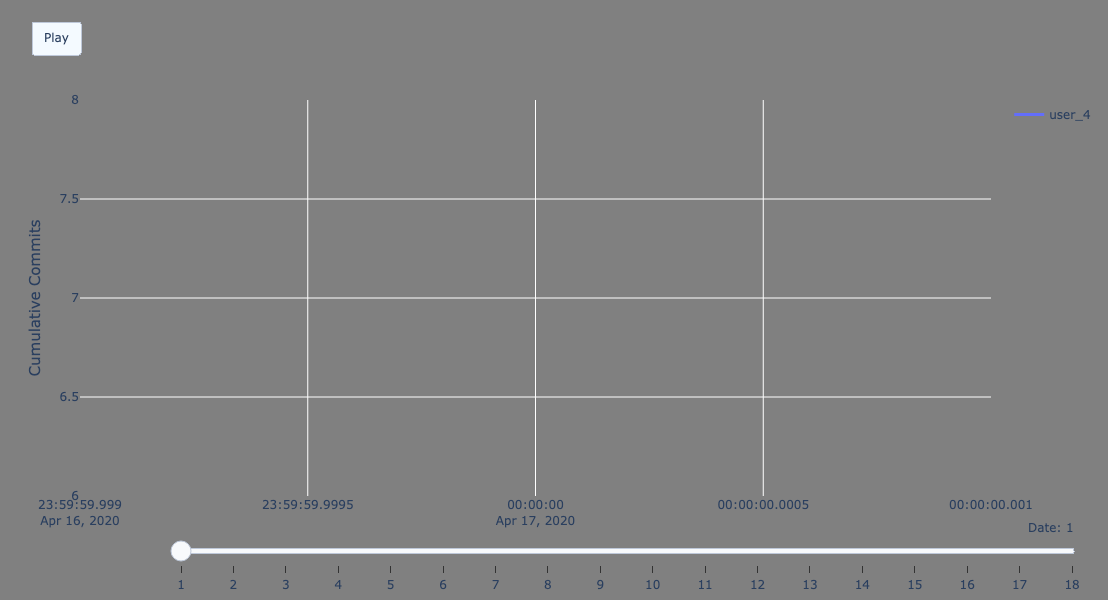

In [15]:
# Кадры анимации
dates = sorted(cumulative_top['date'].unique())
frames = []

for i, date in enumerate(dates):
    frame_data = cumulative_top[cumulative_top['date'] <= date]
    
    traces = []
    for user in top_users:
        user_data = frame_data[frame_data['uid'] == user]
        traces.append(
            go.Scatter(
                x=user_data['date'],
                y=user_data['cumulative_commits'],
                mode='lines',
                name=user,
                line=dict(width=3)
        )
        )   
    frames.append(go.Frame(data=traces, name=str(date)))

# Начальная фигура
fig = go.Figure(
    data=frames[0].data,
    frames=frames
)
# Кнопки play
fig.update_layout(
    updatemenus=[{
        "type": "buttons",
        "buttons": [
            {
                "label": "Play",
                "method": "animate",
                "args": [None, {"frame": {"duration": 200, "redraw": True}}]
            }
        ],
        "x": 0.0,
        "y": 1.2,
        "yanchor": "top"
    }]
)

# Макет
fig.update_layout(
    yaxis_title='Cumulative Commits',
    xaxis_title_font=dict(size=15),
    yaxis_title_font=dict(size=15),
    plot_bgcolor='gray',
    paper_bgcolor='gray',
    height=600,
    width=900,
    showlegend=True
)
# Анимация
fig.update_layout(
    sliders=[{
        "steps": [{
            "args": [[f.name], {"frame": {"duration": 0, "redraw": True}}],
            "label": str(i+1),
            "method": "animate"
        } for i, f in enumerate(frames)],
        "transition": {"duration": 0},
        "x": 0.1,
        "y": 0,
        "currentvalue": {
            "prefix": "Date: ",
            "visible": True,
            "xanchor": "right"
        }
    }]
)

fig.show()

In [16]:
conn.close()